# Stylometric Signature Extraction

#### Ogni feature non misura cosa viene detto, ma come il testo emerge nel tempo: <br> ritmo, distribuzione, regolarità e micro-variazioni. <br> I modelli generativi producono firme statistiche stabili anche quando il contenuto cambia.

In [31]:
!python -m spacy download en_core_web_sm

Traceback (most recent call last):
  File "<frozen runpy>", line 189, in _run_module_as_main
  File "<frozen runpy>", line 148, in _get_module_details
  File "<frozen runpy>", line 112, in _get_module_details
  File "c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\spacy\__init__.py", line 6, in <module>
    from .errors import setup_default_warnings
  File "c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\spacy\errors.py", line 3, in <module>
    from .compat import Literal
  File "c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\spacy\compat.py", line 5, in <module>
    from thinc.util import copy_array
  File "c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\thinc\__init__.py", line 5, in <module>
    from .config import registry
  File "c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\thinc\config.py", line 5, in <module>
    from .types import Decorator
  File "c:\Use

In [ ]:
#!pip install textstat 

In [ ]:
import os 

In [34]:
import numpy as np
import pandas as pd
import re
from collections import Counter
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from itertools import tee
from textblob import TextBlob
from textstat import flesch_reading_ease
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
import spacy


In [36]:
# Carica modello spaCy (disabilita NER per velocità)
nlp = spacy.load("en_core_web_sm", disable=["ner"])

# Carica dataset pulito
df_clean = pd.read_csv('ai_human_clean.csv')
print(f" Dataset caricato: {df_clean.shape[0]} righe, {df_clean.shape[1]} colonne\n")


 Dataset caricato: 48729 righe, 32 colonne



C:\Users\Rosy\AppData\Local\Temp\ipykernel_16444\1580487608.py:5: DtypeWarning: Columns (1,2,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_clean = pd.read_csv('ai_human_clean.csv')


## Utility functions

In [37]:
def pairwise(iterable):
    """Genera coppie consecutive: s -> (s0,s1), (s1,s2), (s2,s3), ..."""
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)


def sentence_lengths(doc):
    """Estrae lunghezze delle frasi"""
    return np.array([len(sent) for sent in doc.sents if len(sent) > 0])


def coefficient_of_variation(x):
    """CV = std/mean - misura variabilità relativa"""
    mu = np.mean(x)
    return np.std(x) / mu if mu > 0 else 0.0


def burstiness_index(x):
    """Burstiness = (σ - μ) / (σ + μ) - irregolarità temporale"""
    mu, sigma = np.mean(x), np.std(x)
    return (sigma - mu) / (sigma + mu) if (sigma + mu) > 0 else 0.0


def safe_entropy(counter: Counter) -> float:
    """Calcola entropia evitando divisioni per zero"""
    values = np.array(list(counter.values()), dtype=float)
    if values.sum() == 0:
        return 0.0
    probs = values / values.sum()
    return entropy(probs)


## R — Rhythmic Control

In [38]:
def rhythmic_features(doc):
    """Firma del ritmo: variabilità lunghezza frasi"""
    lengths = sentence_lengths(doc)
    if len(lengths) == 0:
        return {"sentence_length_cv": 0.0, "burstiness_index": 0.0}
    
    return {
        "sentence_length_cv": coefficient_of_variation(lengths),
        "burstiness_index": burstiness_index(lengths)
    }

## S — Syntactic Entropy

In [39]:
def pos_bigram_entropy(doc):
    """Entropia delle transizioni POS (Part-of-Speech)"""
    pos_tags = [token.pos_ for token in doc]
    if len(pos_tags) < 2:
        return 0.0
    
    bigrams = list(pairwise(pos_tags))
    counts = Counter(bigrams)
    return safe_entropy(counts)


def dependency_depth_mean(doc):
    """Profondità media albero sintattico"""
    depths = []
    for sent in doc.sents:
        for token in sent:
            depth, current = 0, token
            while current.head != current:
                depth += 1
                current = current.head
            depths.append(depth)
    return np.mean(depths) if depths else 0.0


def syntactic_features(doc):
    """Firma sintattica: complessità strutturale"""
    return {
        "pos_bigram_entropy": pos_bigram_entropy(doc),
        "dependency_depth_mean": dependency_depth_mean(doc)
    }

## L — Lexical Efficiency

In [40]:
def lexical_features(doc):
    """Firma lessicale: efficienza comunicativa"""
    tokens = [t for t in doc if t.is_alpha]
    if not tokens:
        return {"lexical_compression_ratio": 0.0, "function_word_ratio": 0.0}
    
    lemmas = [t.lemma_ for t in tokens]
    function_words = [t for t in tokens if t.pos_ in {"DET", "ADP", "AUX", "PRON", "CCONJ", "SCONJ"}]

    return {
        "lexical_compression_ratio": len(set(lemmas)) / len(tokens),
        "function_word_ratio": len(function_words) / len(tokens)
    }

## D — Discourse Regularization


In [41]:
def sentence_similarity_drift(doc):
    """Drift semantico tra frasi consecutive"""
    sentences = [sent.text for sent in doc.sents]
    if len(sentences) < 2:
        return 0.0

    vectors = np.array([nlp(sent).vector for sent in sentences])
    sims = [cosine_similarity([vectors[i]], [vectors[i + 1]])[0][0]
            for i in range(len(vectors) - 1)]
    return float(np.mean(sims))


def structural_redundancy(doc):
    """Ridondanza pattern sintattici"""
    patterns = []
    for sent in doc.sents:
        pattern = tuple(tok.dep_ for tok in sent)
        patterns.append(pattern)
    
    if not patterns:
        return 0.0
    
    counts = Counter(patterns)
    repeated = sum(c for c in counts.values() if c > 1)
    return repeated / len(patterns)


def discourse_features(doc):
    """Firma del discorso: coesione e ridondanza"""
    return {
        "sentence_similarity_drift": sentence_similarity_drift(doc),
        "structural_redundancy": structural_redundancy(doc)
    }

## E — Emotional Variance

In [42]:
def fast_sentiment(text):
    """Sentiment rapido con TextBlob"""
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return 0.0


def emotional_features(doc):
    """Firma emotiva: varianza polarità"""
    sentiments = []
    for sent in doc.sents:
        score = fast_sentiment(sent.text)
        sentiments.append(score)
    
    return {"sentiment_variance": np.std(sentiments) if sentiments else 0.0}


## C — Cognitive Load Distribution

In [43]:
def cognitive_features(doc):
    """Firma cognitiva: complessità lettura"""
    readability = []
    for sent in doc.sents:
        try:
            score = flesch_reading_ease(sent.text)
            readability.append(score)
        except:
            pass
    
    sub_clauses = sum(1 for tok in doc if tok.dep_ in {"advcl", "ccomp", "xcomp", "relcl"})
    sentences = len(list(doc.sents))

    return {
        "readability_oscillation": np.std(readability) if readability else 0.0,
        "clause_density": sub_clauses / sentences if sentences > 0 else 0.0
    }

## HAPAX & TEMPLATE 

In [44]:
def get_hapax_density(text):
    """Hapax Legomena Density - DNA dell'autore"""
    words = re.findall(r'\b\w+\b', str(text).lower())
    if not words:
        return 0.0
    
    word_counts = Counter(words)
    hapax_count = sum(1 for w in word_counts if word_counts[w] == 1)
    return hapax_count / len(words)


def get_template_bias(text):
    """Template Bias Score - La gabbia dell'IA"""
    score = 0.0
    text_lower = str(text).lower()
    
    # A. Liste puntate (molto comuni nell'IA)
    bullet_patterns = [r'^\s*[\-\*•]\s+', r'^\s*\d+[\.\)]\s+']
    if any(re.search(p, text, re.MULTILINE) for p in bullet_patterns):
        score += 1.5
    
    # B. Conclusioni "robotizzate"
    ai_conclusions = ['in conclusion', 'overall', 'to summarize', 
                      'it is important to note', 'in essence']
    if any(phrase in text_lower for phrase in ai_conclusions):
        score += 1.2
    
    # C. Connettivi iper-strutturati
    connectors = ['furthermore', 'moreover', 'additionally', 'consequently']
    connector_count = sum(1 for c in connectors if c in text_lower)
    if connector_count >= 2:
        score += 1.0
    
    return score

## function extraction

In [ ]:
def extract_stylometric_signature(text):
    """
    Estrae la firma stilometrica completa (13 feature).
    Ottimizzata per velocità e robustezza.
    """
    try:
        # Limita lunghezza per performance
        text = str(text)[:10000]
        
        # Parsing spaCy
        doc = nlp(text)
        
        # Estrai tutte le feature
        features = {}
        features.update(rhythmic_features(doc))
        features.update(syntactic_features(doc))
        features.update(lexical_features(doc))
        features.update(discourse_features(doc))
        features.update(emotional_features(doc))
        features.update(cognitive_features(doc))
        
        # Feature avanzate (non richiedono doc spaCy)
        features['hapax_density'] = get_hapax_density(text)
        features['template_bias_score'] = get_template_bias(text)
        
        return pd.Series(features)
    
    except Exception as e:
        # Fallback: restituisci feature nulle
        print(f"Errore nell'elaborazione: {e}")
        return pd.Series({
            "sentence_length_cv": 0.0,
            "burstiness_index": 0.0,
            "pos_bigram_entropy": 0.0,
            "dependency_depth_mean": 0.0,
            "lexical_compression_ratio": 0.0,
            "function_word_ratio": 0.0,
            "sentence_similarity_drift": 0.0,
            "structural_redundancy": 0.0,
            "sentiment_variance": 0.0,
            "readability_oscillation": 0.0,
            "clause_density": 0.0,
            "hapax_density": 0.0,
            "template_bias_score": 0.0
        })

In [46]:
print(f"Numero di righe nel dataset: {df_clean.shape[0]}")


Numero di righe nel dataset: 48729


### APPLICAZIONE AL DATASET

In [51]:
from sklearn.model_selection import train_test_split

# Carica dataset
df_clean = df_clean.dropna(subset=['label_encoded', 'text_cleaned'])
print(f"✅ Dataset dopo pulizia: {df_clean.shape[0]} righe\n")

# ✅ SOLUZIONE: Usa tutte le righe se sono <= 25000
if len(df_clean) <= 25000:
    print(f"ℹ️ Dataset ha {len(df_clean)} righe → uso tutte le righe disponibili")
    df_sampled = df_clean
else:
    # Campiona solo se ci sono più di 25000 righe
    df_sampled, _ = train_test_split(
        df_clean,
        train_size=25000,
        stratify=df_clean['label_encoded'],
        random_state=42
    )

print(f"✅ Dataset finale: {df_sampled.shape[0]} righe")
print("\n📊 Distribuzione classi:")
print(df_sampled['label_encoded'].value_counts())

✅ Dataset dopo pulizia: 25000 righe

ℹ️ Dataset ha 25000 righe → uso tutte le righe disponibili
✅ Dataset finale: 25000 righe

📊 Distribuzione classi:
label_encoded
0.0    15725
1.0     9275
Name: count, dtype: int64


In [52]:
print("\nEstrazione signature stilometriche...")
print("Questa operazione può richiedere 5-10 minuti...\n")

# Applica con progress bar
tqdm.pandas(desc="Processing texts")
signature_df = df_clean['text_cleaned'].progress_apply(extract_stylometric_signature)

print(f"\n Signature estratte: {signature_df.shape[1]} feature")
print(f"   Feature list: {', '.join(signature_df.columns)}\n")

# Merge con dataset originale
print("[Merge con dataset originale...")
df_final = pd.concat([df_clean, signature_df], axis=1)
print(f" Dataset finale: {df_final.shape[0]} righe, {df_final.shape[1]} colonne\n")




Estrazione signature stilometriche...
Questa operazione può richiedere 5-10 minuti...



Processing texts:  30%|███       | 7558/25000 [23:57<55:17,  5.26it/s]  


KeyboardInterrupt: 

In [ ]:
df_final = df_final.iloc[:25000]
# Controllo
print(f"Dataset finale ridotto: {df_final.shape[0]} righe, {df_final.shape[1]} colonne")

# VALIDAZIONE: CONFRONTO AI vs HUMAN

In [ ]:
print("Validazione: Confronto signature AI vs Human")
print("=" * 70)

# Calcolo aggregato
comparison = df_final.groupby('label_encoded')[signature_df.columns].agg(['mean', 'std'])

# Estrai solo le medie
means = comparison.xs('mean', axis=1, level=1)

print("\n MEDIE PER CLASSE:")
print(means.round(3).to_string())

# Differenza assoluta
if 1 in means.index and 0 in means.index:
    diff = means.loc[1] - means.loc[0]
    print("\n DIFFERENZA ASSOLUTA (AI - Human):")
    print(diff.sort_values(ascending=False).round(3).to_string())

    # Top 3 feature discriminanti
    top_discriminant = diff.abs().sort_values(ascending=False).head(3)
    print(f"\n TOP 3 FEATURE DISCRIMINANTI:")
    for feat, value in top_discriminant.items():
        direction = "più alta in AI" if diff[feat] > 0 else "più alta in Human"
        print(f"   • {feat}: Δ = {abs(value):.3f} ({direction})")


Validazione: Confronto signature AI vs Human

 MEDIE PER CLASSE:
               sentence_length_cv  burstiness_index  pos_bigram_entropy  dependency_depth_mean  lexical_compression_ratio  function_word_ratio  sentence_similarity_drift  structural_redundancy  sentiment_variance  readability_oscillation  clause_density  hapax_density  template_bias_score
label_encoded                                                                                                                                                                                                                                                                                    
0                           0.110            -0.838               2.568                  1.957                      0.964                0.361                      0.155                    0.0               0.051                    7.663           0.989          0.946                  0.0
1                           0.078            -0.879              

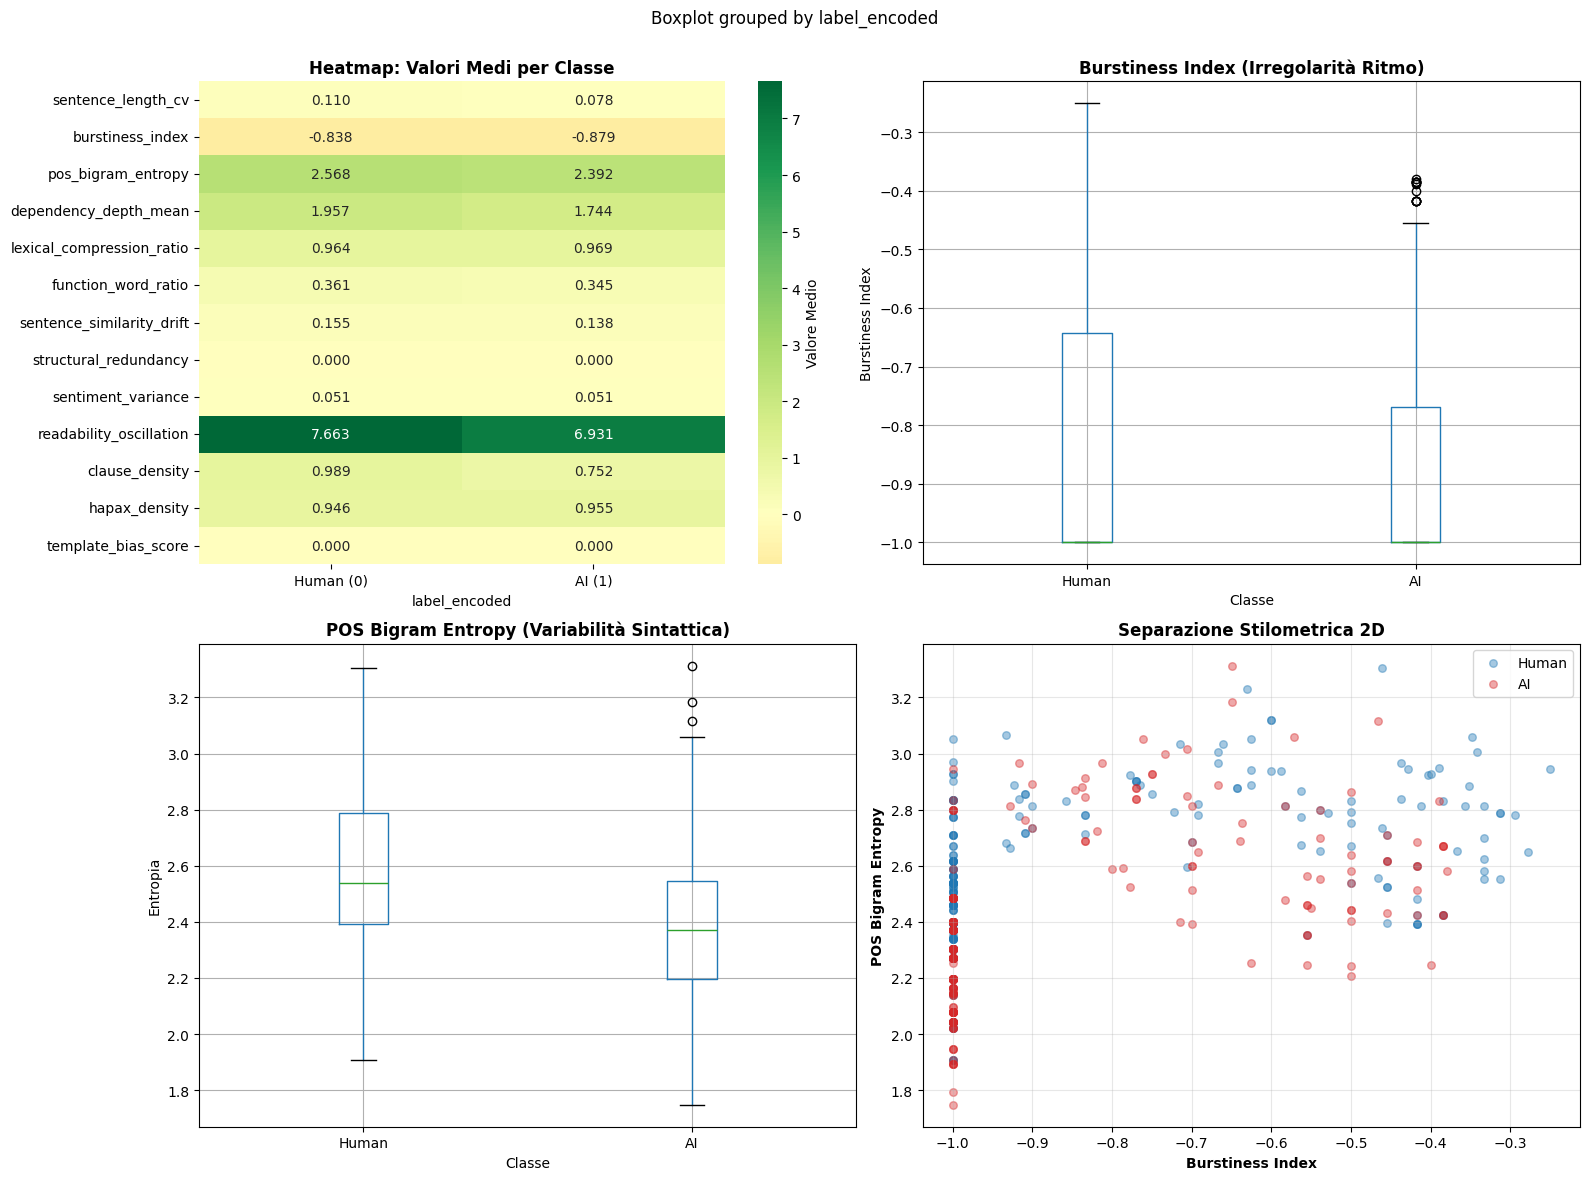


Visualizzazione salvata con successo in: immagini\signature_validation.png


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Signature Stilometriche: Confronto AI vs Human', 
             fontsize=18, fontweight='bold')

# Plot 1: Heatmap comparativa
comparison_pivot = means.T
ax = axes[0, 0]
sns.heatmap(comparison_pivot, annot=True, fmt='.3f', cmap='RdYlGn', 
            center=0, ax=ax, cbar_kws={'label': 'Valore Medio'})
ax.set_title('Heatmap: Valori Medi per Classe', fontweight='bold')
ax.set_xticklabels(['Human (0)', 'AI (1)'])

# Plot 2: Distribuzione burstiness_index
ax = axes[0, 1]
df_final.boxplot(column='burstiness_index', by='label_encoded', ax=ax)
ax.set_title('Burstiness Index (Irregolarità Ritmo)', fontweight='bold')
ax.set_xlabel('Classe')
ax.set_ylabel('Burstiness Index')
ax.set_xticklabels(['Human', 'AI'])
plt.suptitle('')

# Plot 3: Distribuzione pos_bigram_entropy
ax = axes[1, 0]
df_final.boxplot(column='pos_bigram_entropy', by='label_encoded', ax=ax)
ax.set_title('POS Bigram Entropy (Variabilità Sintattica)', fontweight='bold')
ax.set_xlabel('Classe')
ax.set_ylabel('Entropia')
ax.set_xticklabels(['Human', 'AI'])

# Plot 4: Scatter 2D
ax = axes[1, 1]
for label, color in [(0, '#1f77b4'), (1, '#d62728')]:
    subset = df_final[df_final['label_encoded'] == label]
    label_name = 'Human' if label == 0 else 'AI'
    ax.scatter(subset['burstiness_index'], 
               subset['pos_bigram_entropy'],
               alpha=0.4, s=30, c=color, label=label_name)
ax.set_xlabel('Burstiness Index', fontweight='bold')
ax.set_ylabel('POS Bigram Entropy', fontweight='bold')
ax.set_title('Separazione Stilometrica 2D', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)


plt.tight_layout()
fig.subplots_adjust(top=0.92)

# 1. Definiamo il nome della cartella (deve corrispondere a quella creata in VS Code)
output_folder = "immagini"

# 2. Verifichiamo comunque che esista (per evitare errori se sposti lo script)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 3. Definiamo il percorso completo includendo il nome del file
file_path = os.path.join(output_folder, 'signature_validation.png')

# 4. Salviamo l'immagine direttamente nel percorso specifico
plt.savefig(file_path, dpi=300, bbox_inches='tight')

# Opzionale: chiudi la figura per liberare memoria se stai processando molti dati
plt.show()

print(f"\nVisualizzazione salvata con successo in: {file_path}")

## SALVATAGGIO DATASET FINALE

In [ ]:
output_file = 'ai_human_with_signatures.csv'
df_final.to_csv(output_file, index=False)

print("=" * 70)
print("INTEGRAZIONE COMPLETATA CON SUCCESSO!")
print("=" * 70)
print(f"File salvato: '{output_file}'")
print(f"Dimensioni finali: {df_final.shape[0]} righe × {df_final.shape[1]} colonne")
print(f"Signature aggiunte: {signature_df.shape[1]} feature")
print("=" * 70)

INTEGRAZIONE COMPLETATA CON SUCCESSO!
File salvato: 'ai_human_with_signatures.csv'
Dimensioni finali: 500 righe × 52 colonne
Signature aggiunte: 13 feature
